In [1]:
# 1. download HTML files to "html" directory
import requests
import os

if not os.path.exists("html"):
    os.mkdir("html")
    for i in range(10):
        url = "https://www.cityofmadison.com/fire/daily-reports?page="+str(i)
        print(url)
        response = requests.get(url)
        response.raise_for_status()
        with open(os.path.join("html", str(i)+".html"), "w") as f:
            f.write(response.text)

In [2]:
# 2. HTML to DataFrame
import pandas as pd
from bs4 import BeautifulSoup

def html_to_df(path):
    with open(path) as f:
        html = f.read()
    page = BeautifulSoup(html)

    # find the table
    for div_tag in page.find_all("div"):
        if 'pseudo-table' in div_tag.attrs.get("class", []):
            table = div_tag

    rows = []    

    # find the rows
    for div_tag in table.find_all("div"):
        if 'row' in div_tag.attrs.get("class", []):
            row = div_tag
            cells = []
            for div_tag2 in row:
                txt = div_tag2.get_text().strip()
                if txt:
                    cells.append(txt.split(":")[-1].strip())
            rows.append(cells[:4])
    return pd.DataFrame(rows[1:], columns=rows[0])

dfs = []
for i in range(10):
    df = html_to_df(os.path.join("html", str(i)+".html"))
    dfs.append(df)
    
df = pd.concat(dfs).reset_index()
df.head()

,index,Incident,Date,Incident Type,Address
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Block Regent StreetMadison, WI"
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Block Clover LaneMadison, WI"
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 Block John Nolen DriveMadison, WI"
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Block Monroe StMadison, WI"
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 Block S. Stoughton RoadMadison, WI"


In [3]:
# 3. geocoding: address => lat/lon
import geopandas as gpd
gpd.tools.geocode("1210 Dayton Street; Madison, WI")

,geometry,address
0,POINT (-89.40671 43.07156),"Computer Sciences and Statistics, 1210, West D..."


In [4]:
# open street maps, provider name "nominatim"
gpd.tools.geocode("1210 Dayton Street; Madison, WI",
                  provider="nominatim", user_agent="cs320-tyler")

,geometry,address
0,POINT (-89.40671 43.07156),"Computer Sciences and Statistics, 1210, West D..."


In [5]:
# clean addrs: put semicolon before city name, remove word "Block"
df["Address"] = df["Address"].str.replace("Madison", "; Madison").str.replace(" Block ", " ")
df.head()

,index,Incident,Date,Incident Type,Address
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Regent Street; Madison, WI"
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Clover Lane; Madison, WI"
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 John Nolen Drive; Madison, WI"
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Monroe St; Madison, WI"
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 S. Stoughton Road; Madison, WI"


In [15]:
df["geometry"] = None

for idx in df.index:
    addr = df.at[idx, "Address"]
    coord = gpd.tools.geocode(addr, provider="nominatim", user_agent="cs320-tyler").at[0, "geometry"]
    print(addr, coord)
    df.at[idx, "geometry"] = coord
df

3800 Regent Street; Madison, WI POINT (-89.438756 43.068087)
3800 Clover Lane; Madison, WI POINT (-89.322563 43.086765)
10 John Nolen Drive; Madison, WI POINT (-89.38597179999999 43.06628)
2900 Monroe St; Madison, WI POINT (-89.430666 43.056119)
2600 S. Stoughton Road; Madison, WI POINT (-89.30913605303704 43.05826223453485)
5500 Denton Place; Madison, WI POINT (-89.473569 43.030882)
2500 Independence Lane; Madison, WI POINT (-89.30818748575575 43.13135104536706)
1300 Mendota Street; Madison, WI POINT (-89.31761253115809 43.11602884480136)
200 N. First Street; Madison, WI GEOMETRYCOLLECTION EMPTY
2300 S. Park Street; Madison, WI POINT (-89.39549008993453 43.04116985)
6700 Jacobs Way; Madison, WI POINT (-89.4969163424731 43.03811871431542)
8200 Highview Drive ; Madison, WI POINT (-89.523048 43.053662)
1300 N. Sherman Avenue; Madison, WI POINT (-89.36389800000001 43.114368)
Milwaukee Street & West Corporate Drive; Madison, WI GEOMETRYCOLLECTION EMPTY
2200 Independence Lane; Madison, WI P

,index,Incident,Date,Incident Type,Address,geometry
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Regent Street; Madison, WI",POINT (-89.438756 43.068087)
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Clover Lane; Madison, WI",POINT (-89.322563 43.086765)
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 John Nolen Drive; Madison, WI",POINT (-89.38597179999999 43.06628)
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Monroe St; Madison, WI",POINT (-89.430666 43.056119)
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 S. Stoughton Road; Madison, WI",POINT (-89.30913605303704 43.05826223453485)
...,...,...,...,...,...,...
95,5,One Injured In Flash Fire At Oil Change Facility,02/05/2021,Explosion,"3700 Milwaukee Street; Madison, WI",POINT (-89.343378 43.099969)
96,6,Cooking Fire Injures One,01/31/2021,Cooking,"7100 Tree Lane; Madison, WI",POINT (-89.50503014719418 43.06537868114141)
97,7,Carbon Monoxide Buildup the Result of Snow Blo...,01/26/2021,Carbon Monoxide,"2100 Pike Drive; Madison, WI",POINT (-89.41753 43.029675)
98,8,Worker Seriously Injured Following Fall At Con...,01/25/2021,EMS,N. Ingersoll Street & E. Mifflin Street; Madis...,GEOMETRYCOLLECTION EMPTY


In [20]:
# 4. create GeoDataFrame
gpd.GeoDataFrame(df).to_file("fire.geojson")

In [22]:
# 5. draw frame
df = gpd.read_file("fire.geojson")
df.head()

,index,Incident,Date,Incident Type,Address,geometry
0,0,One Injured Following 8-foot Fall Into Open Grate,11/01/2021,Special Rescue,"3800 Regent Street; Madison, WI",POINT (-89.43876 43.06809)
1,1,Fire Caused By Discarded Ashes Damages East Si...,11/01/2021,Trash/Rubbish,"3800 Clover Lane; Madison, WI",POINT (-89.32256 43.08676)
2,2,One Person Rescued From Lake Monona,10/31/2021,Lake Rescue,"10 John Nolen Drive; Madison, WI",POINT (-89.38597 43.06628)
3,3,Dog perishes in early morning fire,10/29/2021,Structure,"2900 Monroe St; Madison, WI",POINT (-89.43067 43.05612)
4,4,Natural Gas Leak Identified In S. Stoughton Ro...,10/20/2021,Gas Leak,"2600 S. Stoughton Road; Madison, WI",POINT (-89.30914 43.05826)


In [30]:
city = gpd.read_file("City_Limit.zip")

<AxesSubplot:>

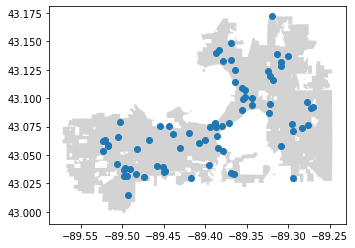

In [34]:
ax = city.plot(color="lightgray")
df.intersection(city.unary_union).plot(ax=ax)

In [ ]:
# df.intersection(df2) # lineup row 0 of df to row 0 of df2, ...
# df.intersection(some shapely shape) # intersect all df rows against the same shape

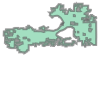

In [36]:
city.unary_union

In [8]:
# 6. create animation